## Imports for Data Extraction and Preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ijson
import logging
import numpy as np
import seaborn as sns

In [2]:
# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

## Parse Data and create DataFrame

In [3]:
def parse_json(file_path, num_events):
    """
    parses the json file and returns a list of events

    :param file_path: path to the json file
    :param num_events: number of events that should be parsed
    """
    with open(file_path, 'rb') as f:
        events = ijson.items(f, 'item')
        limited_events = [next(events) for _ in range(num_events)]
        logger.info('All events parsed. Total number of events: {}'.format(len(limited_events)))
        return limited_events

# specify the number of events that should be preprocessed, max number of events is 264395
num_events = 264395
events = parse_json('stuttgart_events.json', num_events)

# Handle the nested structure of the original json file
events_df = pd.DataFrame(events)
all_keys = set().union(*events_df["eventData"].apply(lambda x: x.keys()))
for key in all_keys:
    events_df[key] = events_df["eventData"].apply(lambda x: x.get(key, None))

keys_location = set().union(*events_df["location"].apply(lambda x: x.keys()))
for key in keys_location:
    events_df[f'location.{key}'] = events_df["location"].apply(lambda x: x.get(key, None))

keys_location_location = set().union(*events_df["location.location"].apply(lambda x: x.keys()))
for key in keys_location_location:
    events_df[f'location.location.{key}'] = events_df["location.location"].apply(lambda x: x.get(key, None))

keys_location_location_address = set().union(*events_df["location.location.address"].apply(lambda x: x.keys()))
for key in keys_location_location_address:
    events_df[f'location.location.address.{key}'] = events_df["location.location.address"].apply(lambda x: x.get(key, None))

INFO:__main__:All events parsed. Total number of events: 264395


## Data Cleaning

In [5]:
# delete dictionary columns
events_df = events_df.drop('eventData', axis=1)
events_df = events_df.drop('location', axis=1)
events_df = events_df.drop('location.location', axis=1)
events_df = events_df.drop('location.location.address', axis=1)

In [6]:
# Only keep events that were not cancelled
events_df = events_df[events_df['cancelled'] == False]
print(events_df.shape)

(261664, 60)


In [7]:
# Only keep events where the location is actually in Stuttgart
events_df = events_df[events_df['location.location.address.city'] == 'Stuttgart']
print(events_df.shape)

(261664, 60)


## Visualize missing values

In [7]:
#Create a heatmap of missing values
plt.figure(figsize=(25, 6))  # Adjust the figure size as needed
sns.heatmap(events_df.isnull(), cmap='viridis', cbar=False)
plt.title('Missing Values Heatmap')
plt.show()

: 

INFO:root:Shape of the DataFrame after dropping columns with more than 80% missing values: (261664, 30)


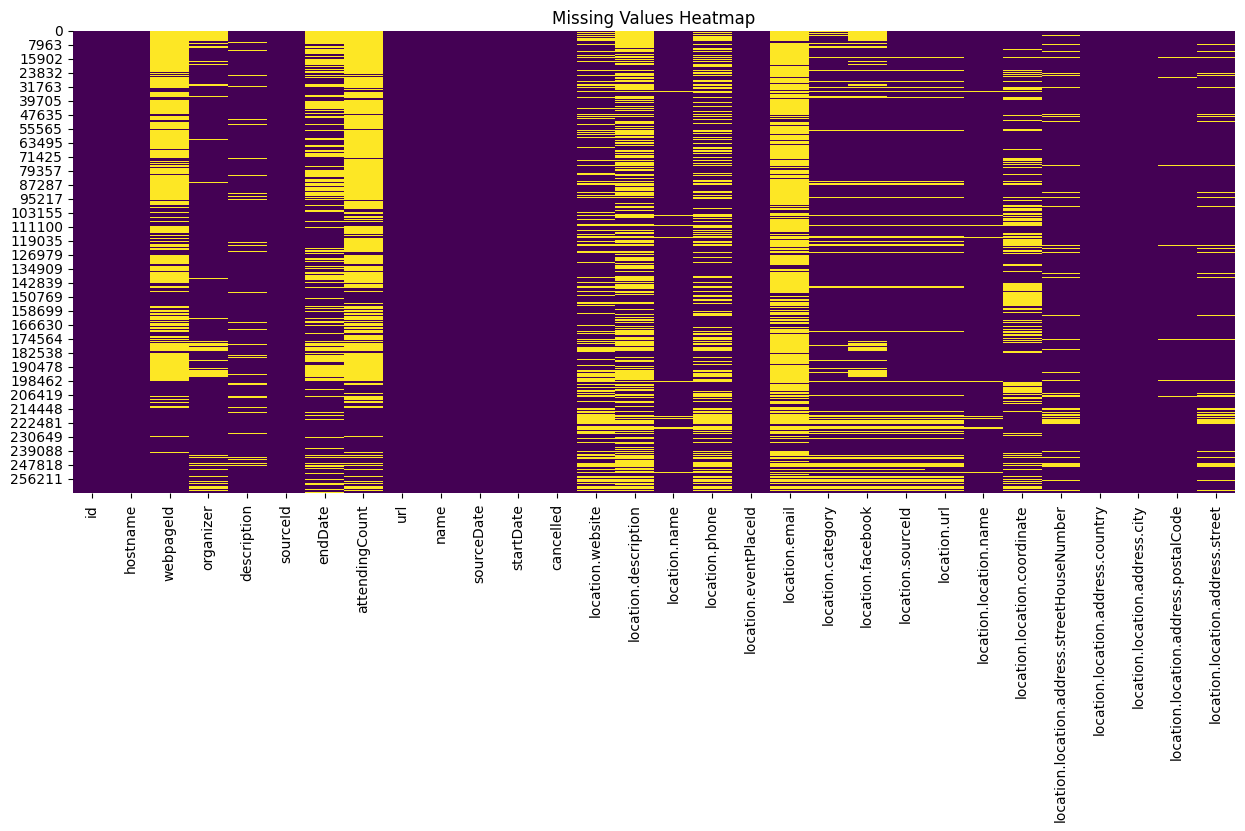

In [8]:
# drop columns with more than 80% missing values
events_df = events_df.dropna(thresh=events_df.shape[0]*0.2, axis=1)
logging.info('Shape of the DataFrame after dropping columns with more than 80% missing values: {}'.format(events_df.shape))
# again plot missing values after cleaning
plt.figure(figsize=(15, 6))  # Adjust the figure size as needed
sns.heatmap(events_df.isnull(), cmap='viridis', cbar=False)
plt.title('Missing Values Heatmap')
plt.show()

## Feature Engineering

### Create Feature "dayofweek" and only consider Wednesdays

In [9]:
if 'startDate' in events_df.columns and events_df['startDate'].dtype != 'datetime64[ns]':
    events_df['startDate'] = pd.to_datetime(events_df['startDate'], format='mixed', utc=True)

# add column for day of week
events_df['dayofweek'] = events_df['startDate'].dt.dayofweek
# only consider events on Wednesdays
events_df = events_df[events_df['dayofweek'] == 2]
events_df.reset_index(drop=True, inplace=True)
# log the number of events remaining
logging.info('Number of events after filtering for Wednesdays: {}'.format(events_df.shape[0]))

INFO:root:Number of events after filtering for Wednesdays: 29549


### Continue with a sample of the data
### NOTE: When the whole dataset of Wednesdays should be used then comment out the following 3 lines

In [ ]:
# sample the data to reduce the number of events, e.g. only select 2000 events
# events_df = events_df.sample(n=2000, random_state=42)
# events_df.reset_index(drop=True, inplace=True)
# logging.info('Number of events after sampling: {}'.format(events_df.shape[0]))

## Derive further time features from the startDate column

In [10]:
# Create year column
events_df['year'] = events_df['startDate'].dt.year
# Create month column
events_df['month'] = events_df['startDate'].dt.month
# Create column with startHour
events_df['starting_hour'] = events_df['startDate'].apply(lambda x: x.hour)

## Extract the season from startDate

In [11]:
# create a function to determine the season
def get_season(date: pd.Timestamp) -> str:
    """
    Returns the season of an event based on the startDate.
    
    :param date: date for which the season should be determined
    :return: season of the given date
    """
    # spring
    if date.month >= 3 and date.month <= 5:
        return 'spring'
    # summer
    elif date.month >= 6 and date.month <= 8:
        return 'summer'
    # autumn
    elif date.month >= 9 and date.month <= 11:
        return 'autumn'
    # winter
    else:
        return 'winter'

# apply the function to the startDate column
events_df['season'] = events_df['startDate'].apply(get_season)

## Derive time_of_day from starting_hour. That's a second derivate feature 😄

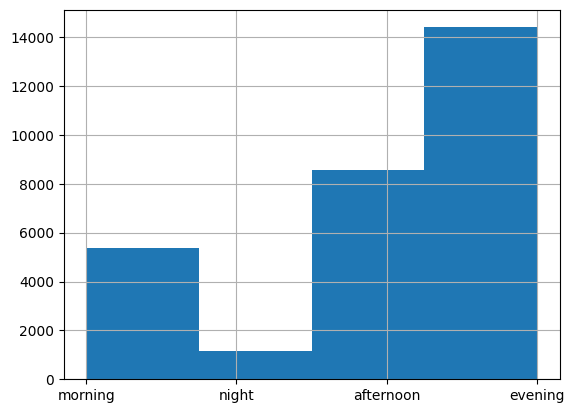

In [12]:
# create a column that classifies the events into morning, afternoon and evening
def get_time_of_day(time: int) -> str:
    """
    returns the time of day of a given start time
    :param time: time for which the time of day should be determined
    :return: time of day of the given time
    """
    # morning
    if time >= 6 and time < 12:
        return 'morning'
    # afternoon
    elif time >= 12 and time < 18:
        return 'afternoon'
    # evening
    elif time >= 18 and time < 24:
        return 'evening'
    # night
    else:
        return 'night'
    
# apply the function to the starting_hour column
events_df['time_of_day'] = events_df['starting_hour'].apply(get_time_of_day)
# plot time_of_day
events_df['time_of_day'].hist(bins=4)
plt.show()

## Map zip codes to district names

In [13]:
# instead of having to choose location based on postcal code, it would be way nicer to choose location based on district
# therefore we need to add a column containing the district of the event
# we can get the district by using a mapping from postcal code to district
# https://home.meinestadt.de/stuttgart/postleitzahlen

zip_code_to_district = {
    "70173": "Europaviertel",
    "70174": "Relenberg",
    "70178": "Karlshöhe",
    "70191": "Am Rosensteinpark",
    "70193": "Kräherwald",
    "70195": "Botnang-West",
    "70197": "Vogelsang",
    "70199": "Südheim",
    "70372": "Bad Cannstatt",
    "70567": "Sternhäule",
    "70569": "Pfaffenwald",
    "70437": "Freiberg",
    "70176": "Rosenberg",
    "70188": "Uhlandshöhe",
    "70374": "Im Geiger",
    "70439": "Zuffenhausen-Elbelen",
    "70190": "Stöckach",
    "70180": "Weinsteige",
    "70182": "Heusteigviertel",
    "70376": "Neckarvorstadt",
    "70378": "Mönchfeld",
    "70597": "Waldau",
    "70565": "Möhringen-Süd",
    "70469": "Feuerbach-Ost",
    "70199": "Südheim"
}


def get_district_from_postcal_code(postcalCode: int):
    """
    returns the district of a given postal code
    :param postcalCode: postal code for which the district should be determined
    :return: district of the given postal code
    """
    try:
        district = zip_code_to_district[str(postcalCode)]
    except KeyError:
        district = "Other"
    return district
    
# apply the function to the postal code column
events_df['district'] = events_df['location.location.address.postalCode'].apply(get_district_from_postcal_code)

## Create features supercategory and subcategory

In [14]:
# split entry in eventData.location.category by / 
def extract_categories(df: pd.DataFrame):
    """
    Extracts the supercategory and subcategory from the eventData.location.category column
    :param df: dataframe containing the events
    :return: dataframe containing the events with two new columns supercategory and subcategory
    """
    events_df['supercategory'] = np.where(events_df['location.category'].notnull(), events_df['location.category'].str.split('/').str[0], 'anderes')
    events_df['subcategory'] = np.where(events_df['location.category'].notnull(), events_df['location.category'].str.split('/').str[1], 'anderes')
    # everything to lowercase
    events_df['supercategory'] = events_df['supercategory'].str.lower()
    events_df['subcategory'] = events_df['subcategory'].str.lower()
    # if subcategory has no value, set it to "No Subcategory"
    events_df['subcategory'] = np.where(events_df['subcategory'].isnull(), 'no subcategory', events_df['subcategory'])
    return events_df

events_df = extract_categories(events_df)

## Save dataframe

In [15]:
events_df.to_csv('all_events.csv', index=False)
logger.info('DataFrame saved to csv file.')

INFO:__main__:DataFrame saved to csv file.


# Adding a Flair to each event

## Imports for flair ingestion

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import pyLDAvis
import pyLDAvis.lda_model
import pandas as pd

## Define Stopwords

In [5]:

# Download German language resources for NLTK
nltk.download('stopwords')
nltk.download('punkt')

# Read DataFrame with event descriptions
df = pd.read_csv('all_events.csv')  # Replace 'your_dataframe.csv' with your actual file path or URL

# Get German stop words from NLTK
german_stop_words = set(stopwords.words('german'))
english_stop_words = set(stopwords.words('english'))
self_defined_stop_words = ['stuttgart', 'de', 'www', 'uhr', '00', '30', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18' '19', '20', '21', '22', '23', '00', '1', 'http', 'com', 'br', 'https', '2020', '2021', '2022', '2023']
# Note: One could have excluded more number. However, some numbers start with 0 in the beginning and then running a loop of numbers to exclude might have been useless.
combined_stop_words = german_stop_words.union(english_stop_words).union(self_defined_stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/juliusdoebelt/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/juliusdoebelt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Convert the event descriptions to a matrix of token counts 

In [6]:
# Convert event descriptions to document-term matrix
vectorizer = CountVectorizer(stop_words=list(combined_stop_words), max_features=1000, max_df=0.85)

event_descriptions = []
for index, row in df.iterrows():
    event_description = row['description']
    if isinstance(event_description, str):
        event_descriptions.append(event_description)
    else:
        event_descriptions.append('Anderes')

X = vectorizer.fit_transform(event_descriptions)

## Apply Latent Dirichlet Allocation (LDA)

In [7]:
num_topics = 5  # Adjust based on the desired number of categories
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
document_topics = lda.fit_transform(X)
print(document_topics)

# Get the most probable topic for each document (event)
predicted_labels = document_topics.argmax(axis=1)

[[0.03368315 0.86526212 0.03365513 0.03373448 0.03366512]
 [0.02532662 0.29030218 0.02514304 0.63398829 0.02523987]
 [0.2        0.2        0.2        0.2        0.2       ]
 ...
 [0.01074215 0.01067948 0.49563257 0.01081202 0.47213378]
 [0.01935737 0.60332685 0.00132896 0.37465924 0.00132758]
 [0.0666667  0.06693163 0.73259094 0.06670034 0.06711039]]


## Visualize the topics

In [8]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(lda, X, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2       -5.410001  -75.670937       1        1  27.142316
3      103.910019   41.236500       2        1  25.661850
1       46.844753  184.831421       3        1  19.631482
4     -113.035568  196.712036       4        1  16.280139
0     -107.118210   41.419109       5        1  11.284213, topic_info=            Term         Freq        Total Category  logprob  loglift
213           dj  2723.000000  2723.000000  Default  30.0000  30.0000
506         kurs  1947.000000  1947.000000  Default  29.0000  29.0000
972         yoga  1839.000000  1839.000000  Default  28.0000  28.0000
93          band  2455.000000  2455.000000  Default  27.0000  27.0000
34            ab  5475.000000  5475.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
5             19   565.527900  5079.358598   Topic5  -4.8611  -0.0134
497       kosten   396.168826   780.638625   Topic5  -5.2171   1.5035
279         euro   436.836125  1597.245830   Topic5  -5.1193   0.8853
835  stuttgarter   423.552140  2627.504848   Topic5  -5.1502   0.3567
572         mehr   423.157302  4163.502928   Topic5  -5.1512  -0.1046

[321 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
4         1  0.354095       18
4         2  0.098447       18
4         3  0.022719       18
4         4  0.264527       18
4         5  0.260349       18
...     ...       ...      ...
994       3  0.313168     zwei
994       4  0.084995     zwei
994       5  0.008557     zwei
999       1  0.002224  übungen
999       5  0.996302  übungen

[765 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 5, 1])

In [9]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic #{topic_idx}: "
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)

n_top_words = 20
tf_feature_names = vectorizer.get_feature_names_out()
print_top_words(lda, tf_feature_names, n_top_words)

Topic #0: kurs yoga 18 anmeldung kannst körper stadtpalais ausstellung ab bewegung lernen dabei 19 kennen sowie termine hast möglich museum minuten
Topic #1: band musik live album tour songs jazz rock new seit musiker pop jahren deutschland konzert bass sound mehr music wurde
Topic #2: anmeldung 19 veranstaltung freuen württemberg baden findet dr bitte fragen statt sowie 18 informationen weitere mittwoch thema mehr 2019 eur
Topic #3: immer leben gibt mehr zeit welt eintritt schon menschen 19 geht dabei mal film jahren ganz kommt viele wer mittwoch
Topic #4: ab dj mittwoch club facebook gibt party eintritt 18 geht tickets 50 einfach 19 abend mal heute bar einlass salsa


## Assign labels for each topic

In [10]:
# Map the topic labels to your predefined categories
# NOTE: The topic number of the plot does not correspond with the actual number, therefore the printed topic words above.
topic_labels_mapping = {
    0: 'Körperbewusst',
    1: 'Musikalisch',
    2: 'Informativ',
    3: 'Gesellig',
    4: 'Energetisch'
}

# Map the predicted labels to category names
predicted_category_labels = [topic_labels_mapping[label] for label in predicted_labels]

# Add the predicted category labels to the DataFrame
df['stimmung'] = predicted_category_labels

## Check Output

In [11]:
# Print or further analyze the predicted category labels
print(df[['description', 'stimmung']])

                                             description       stimmung
0      Freidrich Achleitner liest Prosa, Künstler Mic...    Musikalisch
1      Stuttgart ist ungewöhnlich reich an besonders ...       Gesellig
2                                                    NaN  Körperbewusst
3                                                    NaN  Körperbewusst
4      <div class="bbcode">Charlie Musselwhite – die ...    Musikalisch
...                                                  ...            ...
29544  OneRepublic at Porsche Arena on Nov 2, 2022\n\...     Informativ
29545                                                NaN  Körperbewusst
29546  KUNST-COMPUTER-CLUB ➤ MITTWOCHS, 16-17:30 Uhr ...     Informativ
29547  Provinz\n"Zorn & Liebe" Tour 2022\nPräsentiert...    Musikalisch
29548  Duman at LKA Longhorn at 2022-12-21\n\nLine-Up...     Informativ

[29549 rows x 2 columns]


In [13]:
df.shape

(29549, 40)

## Save dataframe with Flair

In [14]:
df.to_csv('all_events.csv', index=False)

: 